In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
from glob import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2
from PIL import Image
import pickle

import torch
from torch import nn, utils
import monai
import wandb
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from torch.cuda.amp import GradScaler
import gc

## Data preprocessing

In [5]:
folder_path = '/content/drive/MyDrive/test_visionlabs/task'
images_path = os.path.join(folder_path, 'images')
labels_path = os.path.join(folder_path, 'labels')

In [6]:
os.chdir(images_path)
images_cases = glob('*id*')
cases = ['_'.join(case.split('_')[:-1]) for case in images_cases]

In [7]:
cases_3d = list(set(['_'.join(case.split('_')[:2]) for case in cases]))

In [8]:
cases_match = {}
for case in cases_3d:
  cases_match[case] = sorted(list(filter(lambda x: case in x, cases)))

In [9]:
def draw_contours(image_origin, predict_label):
    colours=[(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255)]
    image = cv2.cvtColor((((image_origin-image_origin.min())/(image_origin.max()-image_origin.min()))*255).astype('uint8'), cv2.COLOR_GRAY2RGB)

    for x in np.unique(predict_label.astype('uint8')):
        if x!=0:
            contours,_=cv2.findContours(image=(predict_label==x).astype('uint8'), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
            cv2.drawContours(image=image,  contours=contours, contourIdx=-1,  color=colours[x-1],  thickness=2,)
    im = Image.fromarray(image)
    return im

Для обучения объединяю классы левая/права почка в один. На постпроцессинге разделю обратно

In [10]:
labels_mapping = {
    0: 0,
    1: 1,
    2: 2,
    3: 2,
    6: 3,
    7: 4,
    8: 5,
    9: 6
}

wasted_labels = [4, 5, 10, 11, 12]

Т.к. данные в 2d формате ~8гб, можно загрузить их в оперативную память.

In [30]:
data = {}

def process_case(case):
    case_data = []

    im = np.load(os.path.join(images_path, f'{case}_img.npy'))
    im = im.astype('float32')

    mask = np.load(os.path.join(labels_path, f'{case}_lbl.npy'))
    mask = mask.astype('uint8')
    mask_cleaned = np.where(np.isin(mask, wasted_labels), 0, mask)
    map_func = np.vectorize(lambda x: labels_mapping.get(x, x))
    mask_mapped = map_func(mask_cleaned)

    case_data.append(im)
    case_data.append(mask_mapped)

    return case_data

with ThreadPoolExecutor() as executor:
    case_results = list(tqdm(executor.map(process_case, cases), total=len(cases)))

for case, case_data in zip(cases, case_results):
    data[case] = case_data

100%|██████████| 2622/2622 [02:38<00:00, 16.53it/s]


Предложено окно для мягких тканей (-350, 400), уточню его на основе значений средней интенсивности для каждого класса -- (-150, 300)

In [32]:
intens = {
    '1': [],
    '2': [],
    '3': [],
    '4': [],
    '5': [],
    '6': []
    }

for key in tqdm(data.keys()):
  for lbl in intens.keys():
    intens[lbl].append(np.mean(data[key][0][data[key][1] == int(lbl)]))

100%|██████████| 2622/2622 [00:03<00:00, 690.67it/s]


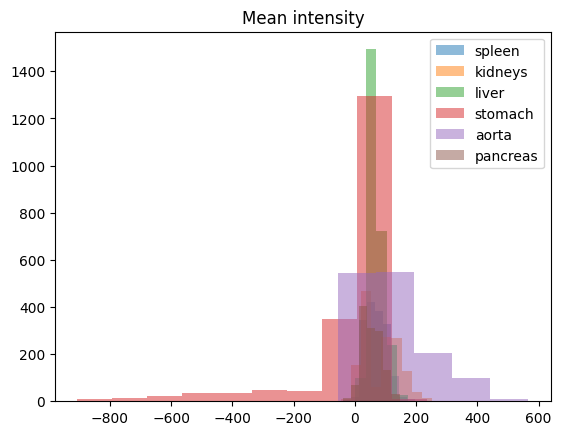

In [33]:
for key, name in zip(intens.keys(), ['spleen', 'kidneys', 'liver', 'stomach', 'aorta', 'pancreas']):
  plt.hist([x for x in intens[key] if str(x) != 'nan'], alpha=0.5, label=name)
  plt.legend()
  plt.title('Mean intensity')

Разбиение на трейн и валидационныю выборку произвожу, группируя кейсы по КТ, чтобы срезы с одного и того же исследования не присутствовали одновременно в трейне и валидации. Добавляю stratify на вид датасета -- amos/ts

In [34]:
stratify = [case.split('_')[0] for case in cases_3d]

In [35]:
train_3d_cases, val_3d_cases = train_test_split(cases_3d, test_size=0.15, stratify=stratify, random_state=0)

In [36]:
train_2d_cases = list(filter(lambda x: '_'.join(x.split('_')[:-1]) in train_3d_cases, cases))
val_2d_cases = list(filter(lambda x: '_'.join(x.split('_')[:-1]) in val_3d_cases, cases))

In [37]:
len(train_2d_cases), len(val_2d_cases)

(2226, 396)

In [38]:
# with open(os.path.join(folder_path, 'train_2d_cases.txt'), 'wb') as f_in:
#     pickle.dump(train_2d_cases, f_in)

# with open(os.path.join(folder_path, 'val_2d_cases.txt'), 'wb') as f_in:
#     pickle.dump(val_2d_cases, f_in)

Для страта обучения выбираю кроп по медианному размеру, кратному 32 -- (480, 576), в процессе увеличиваю до (480, 704)

In [45]:
sizes = [data[case][0].shape for case in train_2d_cases]
np.median(np.array(sizes)[:,0]), np.median(np.array(sizes)[:,1]) # 480 576

(500.0, 564.0)

## Train

In [14]:
class GetDataset(utils.data.Dataset):
  def __init__(
      self,
      images_folder,
      masks_folder,
      cases_path,
      augmentation=None
    ):
      with open(cases_path, 'rb') as f_in:
          self.cases = pickle.load(f_in)

      self.images = [os.path.join(images_folder, image_id+'_img.npy') for image_id in self.cases]
      self.masks = [os.path.join(masks_folder, image_id+'_lbl.npy') for image_id in self.cases]

      self.augmentation = augmentation

  def __getitem__(self, i):

    image = np.load(self.images[i])
    image = image.astype('float32')

    mask = np.load(self.masks[i])
    mask = mask.astype('uint8')
    mask_cleaned = np.where(np.isin(mask, wasted_labels), 0, mask)
    map_func = np.vectorize(lambda x: labels_mapping.get(x, x))
    mask_mapped = map_func(mask_cleaned)

    data_aug = {
        'image': np.expand_dims(image, 0),
        'label': np.expand_dims(mask_mapped, 0)
    }

    sample = self.augmentation(data_aug)
    image, mask = sample['image'], sample['label']

    return image, mask
  def __len__(self):
    return len(self.cases)

In [15]:
class GetDatasetFromRAM(utils.data.Dataset):
  def __init__(
      self,
      data,
      cases_path,
      augmentation=None
    ):
      with open(cases_path, 'rb') as f_in:
          self.cases = pickle.load(f_in)

      self.augmentation = augmentation
      self.data = data

  def __getitem__(self, i):

    image = self.data[self.cases[i]][0]
    mask = self.data[self.cases[i]][1]

    data_aug = {
        'image': np.expand_dims(image, 0),
        'label': np.expand_dims(mask, 0)
    }

    sample = self.augmentation(data_aug)
    image, mask = sample['image'], sample['label']

    return image, mask
  def __len__(self):
    return len(self.cases)

Аугументации усиливала в ходе эксперементов, отсматривала результаты преобразований, подбирая параметры

In [50]:
train_transforms = monai.transforms.Compose(
    [
        monai.transforms.RandGaussianNoised(keys=['image'], prob=0.6, std=0.25),
        monai.transforms.RandGaussianSmoothd(keys=['image'], sigma_x=(1.5, 4.5),
                                              approx='erf', prob=0.6, allow_missing_keys=False),
        monai.transforms.RandScaleIntensityd(keys=["image"], factors=0.9, prob=0.6),
        monai.transforms.RandShiftIntensityd(keys=["image"], offsets=0.9, prob=0.6),

        monai.transforms.ScaleIntensityRanged(keys=["image"], a_min=-150, a_max=300, b_min=0.0, b_max=1.0, clip=True),

        monai.transforms.RandAffined(keys=['image', 'label'], prob=0.6,
                                     rotate_range=(-np.pi/15, np.pi/15), scale_range=(0.2, 0.2), shear_range=(0.3, 0.3),
                                     mode=('bilinear', 'nearest'), padding_mode='zeros'),

        monai.transforms.Rand2DElasticd(keys=['image', 'label'],
                                        prob=0.4,
                                        spacing=(10, 10),
                                        magnitude_range=(1, 2),
                                        padding_mode="zeros",
                                        mode=('bilinear', 'nearest')),

        monai.transforms.RandSpatialCropd(keys=["image", "label"], roi_size=(480, 704),
                                          random_size=False),
        monai.transforms.SpatialPadd(keys=["image", "label"], spatial_size=(480, 704)),
        monai.transforms.ToTensord(keys=["image", "label"]),
    ]
)

val_transforms = monai.transforms.Compose(
    [
        monai.transforms.ScaleIntensityRanged(keys=["image"], a_min=-150, a_max=300, b_min=0.0, b_max=1.0, clip=True),
        monai.transforms.DivisiblePadd(keys=["image", "label"], k=32),
        monai.transforms.ToTensord(keys=["image", "label"]),
    ]
)

In [51]:
train_dataset = GetDatasetFromRAM(
    data,
    os.path.join(folder_path, 'train_2d_cases.txt'),
    augmentation=train_transforms
    )

valid_dataset = GetDatasetFromRAM(
    data,
    os.path.join(folder_path, 'val_2d_cases.txt'),
    augmentation=val_transforms
    )

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=2)
val_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


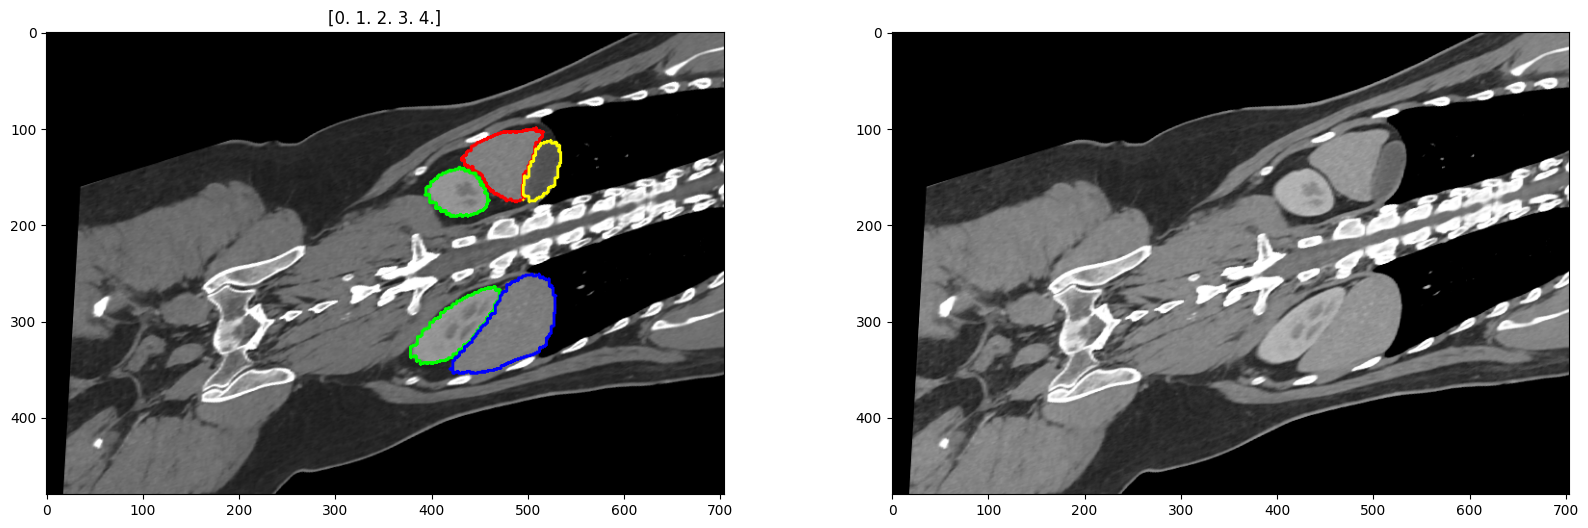

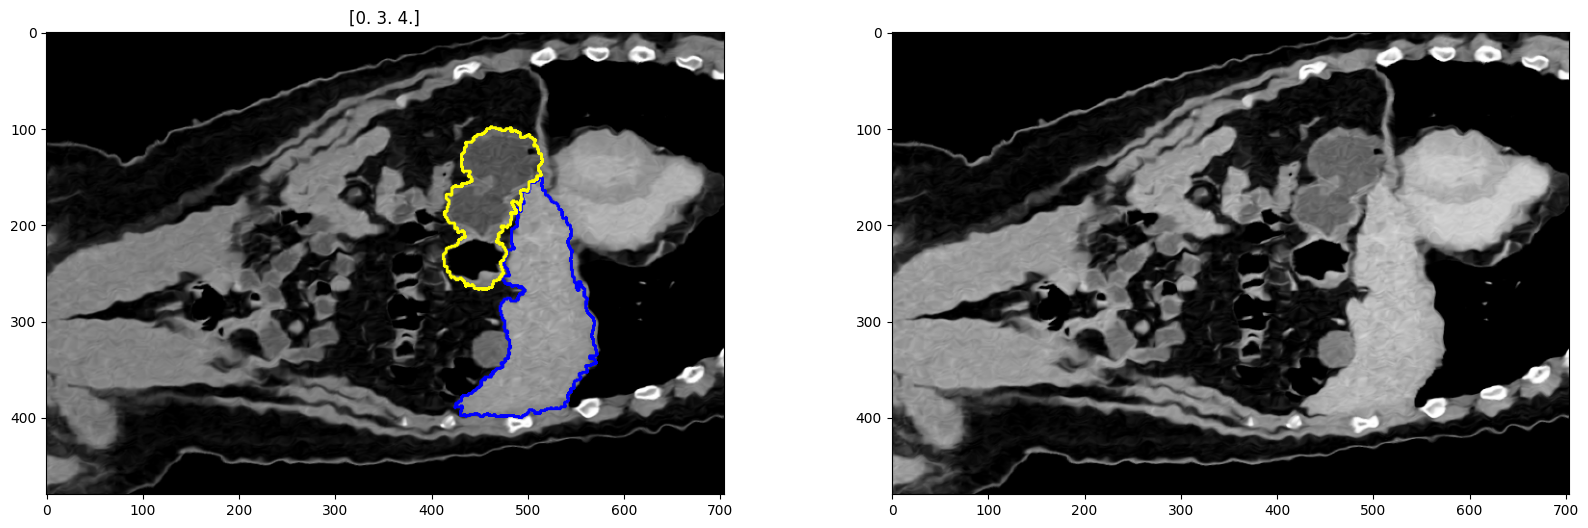

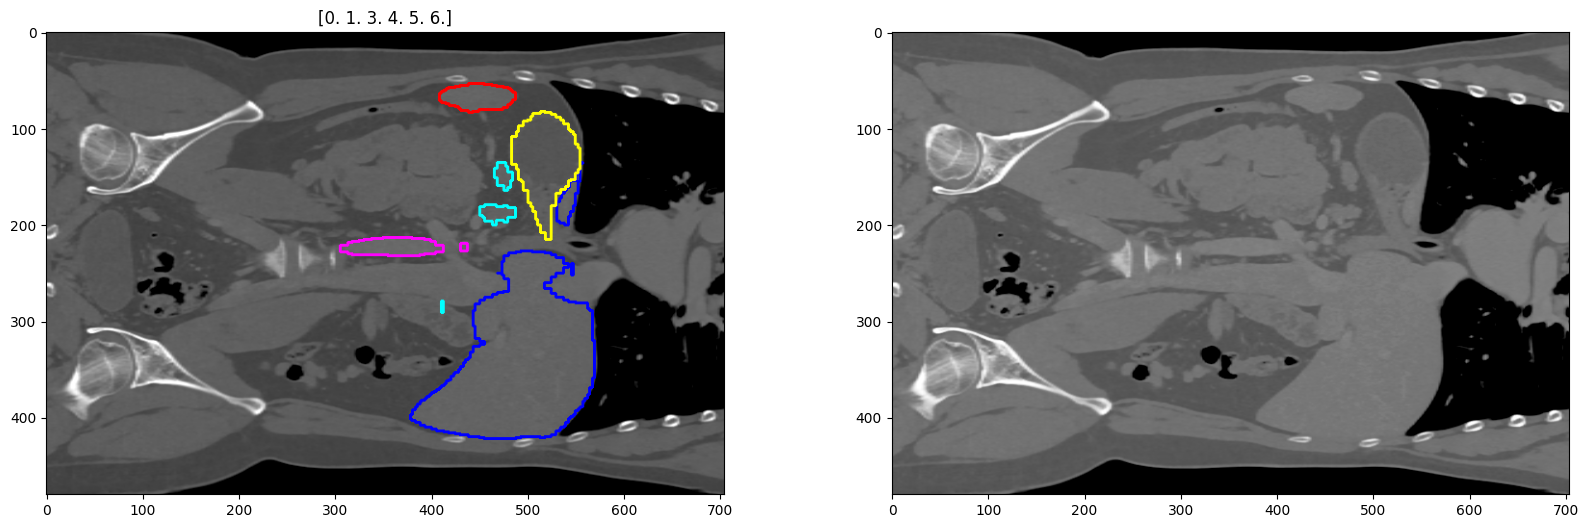

In [52]:
offset = 0

for i in range(3):
    image, mask = train_dataset[offset+i]
    image, mask = image[0], mask[0]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
    ax[0].imshow(draw_contours(image.numpy(), mask.numpy()))
    ax[0].set_title(np.unique(mask))
    ax[1].imshow(image, 'Greys_r')

Для обучания выбирала:

*   Тверский лосс c `gamma=2`, в ходе эксперементов понизила `alpha` c 0.5 до 0.4, сильнее штрафуя за ложноотрицательные предсказания
*  `Cross entropy loss` из pytorch.  Подбирая веса классов, ориентируясь на промежутьчные результаты обучения. Так же для борьбы с переобучением добавила label smoothing


In [19]:
def tversky_loss(outputs, targets, class_label, alpha=0.4, gamma=2):
  smooth = 1
  beta = 1 - alpha

  output = torch.squeeze(outputs[:,class_label])
  target = torch.squeeze((targets == class_label).int())

  intersection = (output * target).sum()
  FP = ((1-target) * output).sum()
  FN = (target * (1-output)).sum()
  tv = (intersection + smooth) / (intersection + alpha*FP + beta*FN + smooth)
  tversky = 1. - tv
  return tversky ** gamma

def tversky_multi(outputs, targets):
  outputs = torch.softmax(outputs, dim=1)
  return reduce(lambda a, b: a+b, [tversky_loss(outputs, targets, i) for i in range(7)])/7

Основаная метрика - dice по всем классам

In [20]:
def dice_coef(outputs, targets):
    smooth = 1.0
    dsc = []
    for class_label in range(1,7):
        output = (outputs == (class_label)).float()
        target = (targets == (class_label)).float()
        output = output.view(-1)
        target = target.view(-1)
        intersection = (output * target).sum()
        dsc.append(((2. * intersection + smooth) / (output.sum() + target.sum() + smooth)).item())
    return dsc

In [21]:
!nvidia-smi

Fri Feb  9 14:38:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Для контроля хода обучения использую `wandb`, логируя на каждой эпохе значения loss'ов, dice'ов и предсказание маски на кейсе из валидации

Выбрала архитектуру `SegResNet` с deep supervision потому что:


*   multi-scale feature fusion -- улучшает качетсво сегментации объектов разных размеров
*   skip connection между блоками энкодера с несколькими блоками декодера на разных уровнях улучшает поток информации
* добавление residual blocks к UNet-like архитектуре
* deep supervision улучшает поток градиента и позволяет контролировать извлечение признаков на разных уровнях. С помощью интерполяции перевожу ground truth в размерность логитов со скрытых слоев


Стартовала обучение `learning_rate = 1e-3`, обновляла его с помощью scheduler `ReduceLROnPlateau`

Обучаюсь с mixed precision для оптимизации обучения памяти и времени.

Обучалась на V100 в GoogleColab


In [53]:
config = dict(
    architecture='SegResNetDS',
    init_filters=32,
    dsdepth=4,
    epochs=100,
    initial_lr=2e-4,
    scheduler_factor=0.6,
    scheduler_patience = 5
)

with wandb.init(
    project='VisionLabs_TestTask',
    config=config
  ) as run:
  model_name = 'SegRes_' + run.name

  model = monai.networks.nets.SegResNetDS(
      spatial_dims=2,
      init_filters=32,
      in_channels=1,
      out_channels=7,
      act='relu',
      norm='batch',
      blocks_down=(1, 2, 2, 2, 4),
      dsdepth=4,
      upsample_mode='deconv'
  ).cuda()

  model.load_state_dict(torch.load(os.path.join(folder_path, 'model_SegRes_young-morning-27.ckpt')))

  optimizer = optim.Adam(model.parameters(), lr=wandb.config['initial_lr'], weight_decay=1e-5)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(
      optimizer,
      factor=wandb.config['scheduler_factor'],
      patience=wandb.config['scheduler_patience'],
      threshold=1e-4,
      mode="min"
  )

  best_mean_dice = 0
  scaler = GradScaler()
  ce_loss = nn.CrossEntropyLoss(weight=torch.Tensor([1.]*6+[1.1]).cuda(), label_smoothing=0.05)

  for epoch in range(wandb.config['epochs']):
    print('* Epoch %d/%d' % (epoch+1, (wandb.config['epochs'])))

    avg_loss = 0
    dice_scores = np.zeros((6))

    model.train()
    for X_batch, Y_batch in tqdm(train_loader):
      X_batch, Y_batch = X_batch.cuda(), Y_batch.cuda()

      optimizer.zero_grad()
      with torch.autocast(device_type="cuda", dtype=torch.float16):

        Y_pred = model(X_batch)
        loss = 0
        for pred in Y_pred:
          Y_resized = nn.functional.interpolate(Y_batch, size=pred.shape[2:], mode='nearest')

          ce = ce_loss(pred, Y_resized[:,0].long())
          tv = tversky_multi(pred, Y_resized)

          loss += tv + ce

      loss /= len(Y_pred)

      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()

      avg_loss += loss / len(train_loader)
      Y_pred_arg = torch.softmax(Y_pred[0], dim=1).argmax(dim=1, keepdim=True)
      dice_scores += dice_coef(Y_pred_arg, Y_batch)

    gc.collect()
    torch.cuda.empty_cache()

    dice_scores /= len(train_loader)

    trn_data = {
        'learning_rate': optimizer.param_groups[0]['lr'],
        'Train/loss': avg_loss.item(),
    }

    for i in range(1,7):
      trn_data[f'Train/dice_{i}'] = dice_scores[i-1]

    avg_loss = 0
    dice_scores = np.zeros((6))

    model.eval()
    with torch.no_grad():
      for X_batch, Y_batch in tqdm(val_loader):
        X_batch, Y_batch = X_batch.cuda(), Y_batch.cuda()

        Y_pred = model(X_batch)

        ce = ce_loss(Y_pred, Y_batch[:,0].long())

        Y_pred = torch.softmax(Y_pred, dim=1)
        tv = tversky_multi(Y_pred, Y_batch)

        loss = tv + ce

        avg_loss += loss / len(val_loader)
        Y_pred_arg = Y_pred.argmax(dim=1, keepdim=True)
        dice_scores += dice_coef(Y_pred_arg, Y_batch)

    scheduler.step(avg_loss)

    gc.collect()
    torch.cuda.empty_cache()

    dice_scores /= len(val_loader)

    if np.mean(dice_scores) >= best_mean_dice:
      print('save model')
      torch.save(model.state_dict(), os.path.join(folder_path, f'model_{model_name}.ckpt'))
      torch.save(optimizer.state_dict(), os.path.join(folder_path, f'opt_{model_name}.ckpt'))
      best_mean_dice = np.mean(dice_scores)

    val_data = {
        'Val/loss': avg_loss.item(),
    }

    for i in range(1,7):
      trn_data[f'Val/dice_{i}'] = dice_scores[i-1]

    table = wandb.Table(columns=['ID', 'Image'])

    labels = {
        0: 'background',
        1: 'spleen',
        2: 'kidneys',
        3: 'liver',
        4: 'stomach',
        5: 'aorta',
        6: 'pancreas'
    }

    for num, img, mask_pred, mask_true in zip(range(len(X_batch)), X_batch, Y_pred_arg, Y_batch):
      img = np.squeeze(img.cpu().numpy())
      mask_pred = np.squeeze(mask_pred.cpu().numpy())
      mask_true = np.squeeze(mask_true.cpu().numpy())

      image = wandb.Image(img, masks={
          'prediction': {
              'mask_data': mask_pred,
              'class_labels': labels
          },
          'ground_truth': {
              'mask_data': mask_true,
              'class_labels': labels
          }
      })

      table.add_data(num, image)

    wandb.log({
        **trn_data,
        **val_data,
        'Images': table
    })

## Predictions

Результаты на валидации

In [24]:
model = monai.networks.nets.SegResNetDS(
      spatial_dims=2,
      init_filters=32,
      in_channels=1,
      out_channels=7,
      act='relu',
      norm='batch',
      blocks_down=(1, 2, 2, 2, 4),
      dsdepth=4,
      upsample_mode='deconv'
).cuda()

model.load_state_dict(torch.load(os.path.join(folder_path, 'model_SegRes_stellar-armadillo-30.ckpt')))

<All keys matched successfully>

In [25]:
dice_scores = []
X, Y, pred = [], [], []
model.eval()
with torch.no_grad():
  for i, (X_batch, Y_batch) in tqdm(enumerate(val_loader)):
    X_batch, Y_batch = X_batch.cuda(), Y_batch.cuda()

    Y_pred = model(X_batch)
    Y_pred = torch.softmax(Y_pred, dim=1)
    Y_pred_arg = Y_pred.argmax(dim=1, keepdim=True)
    dice_scores.append(dice_coef(Y_pred_arg, Y_batch))
    X.append(X_batch[0,0].cpu().numpy())
    Y.append(Y_batch[0,0].cpu().numpy())
    pred.append(Y_pred_arg[0,0].cpu().numpy())

396it [00:13, 28.92it/s]


In [26]:
dice_per_classes = [np.mean(np.array(dice_scores)[:,i]) for i in range(6)]

In [27]:
for name, dice in zip(['spleen', 'kidneys', 'liver', 'stomach', 'aorta', 'pancreas'], dice_per_classes):
  print(f'{name} dice: {dice}')

spleen dice: 0.9066576809398778
kidneys dice: 0.9043450189288853
liver dice: 0.9691868705881966
stomach dice: 0.8674781821277378
aorta dice: 0.8932734107009384
pancreas dice: 0.8417008700158072


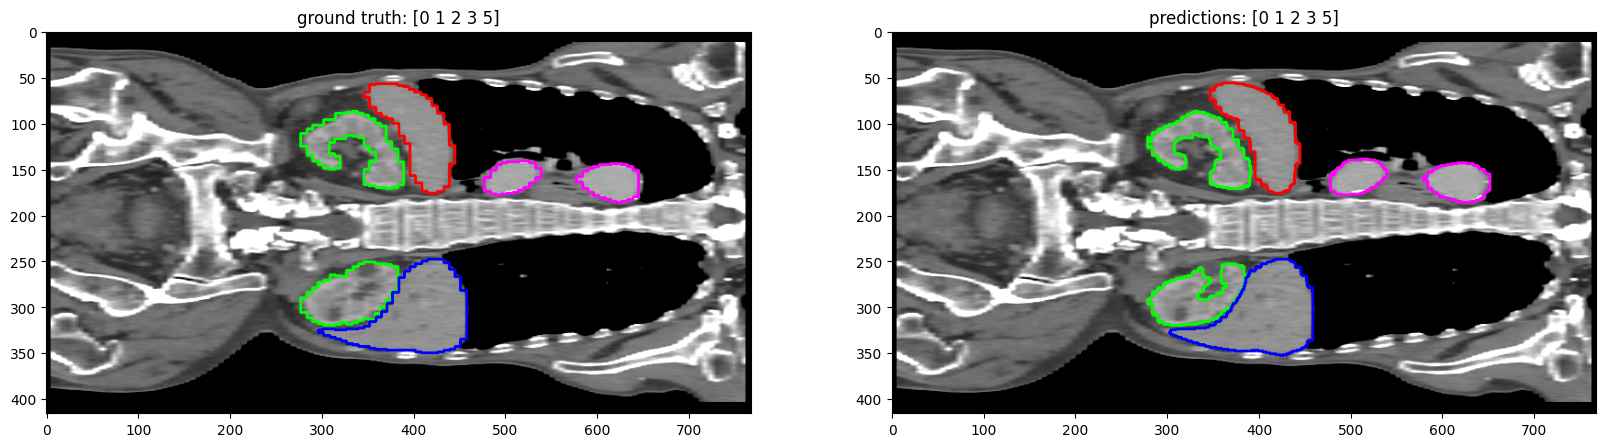

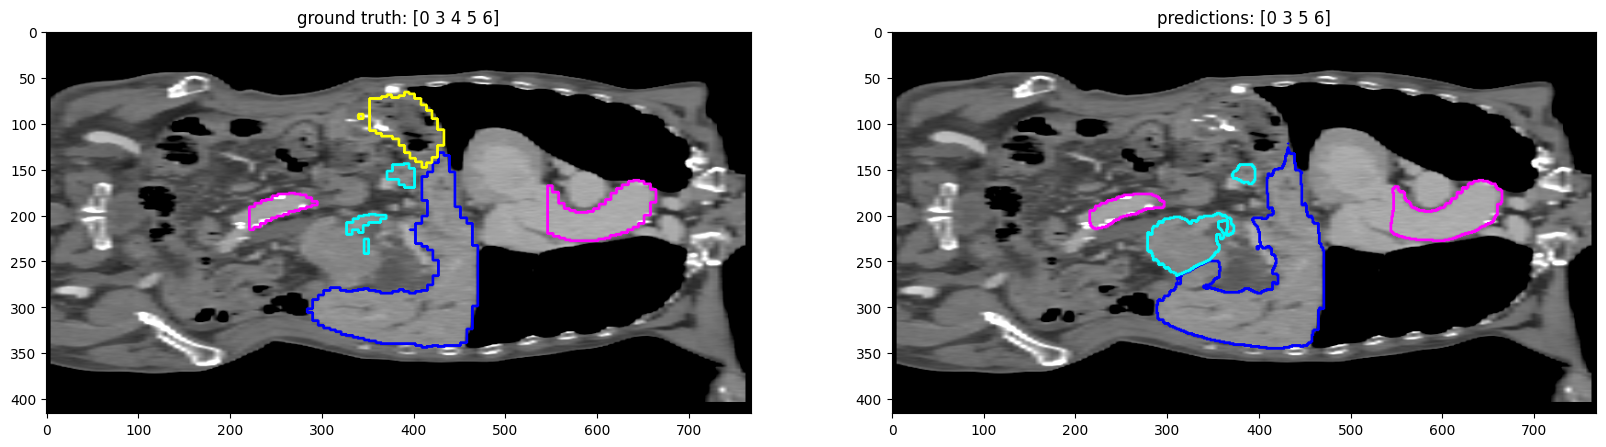

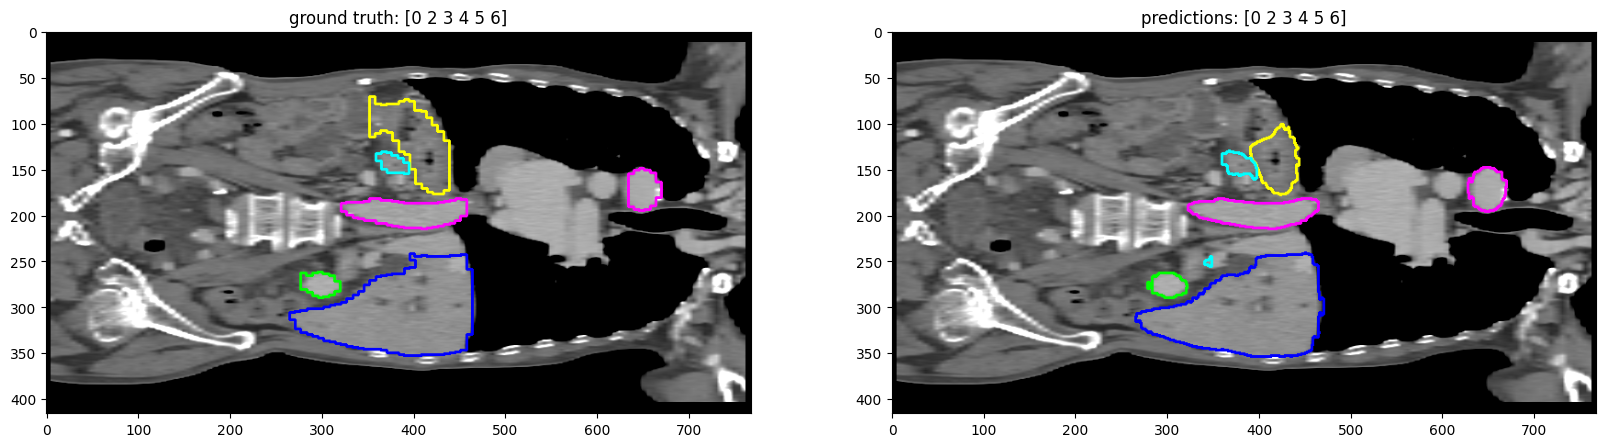

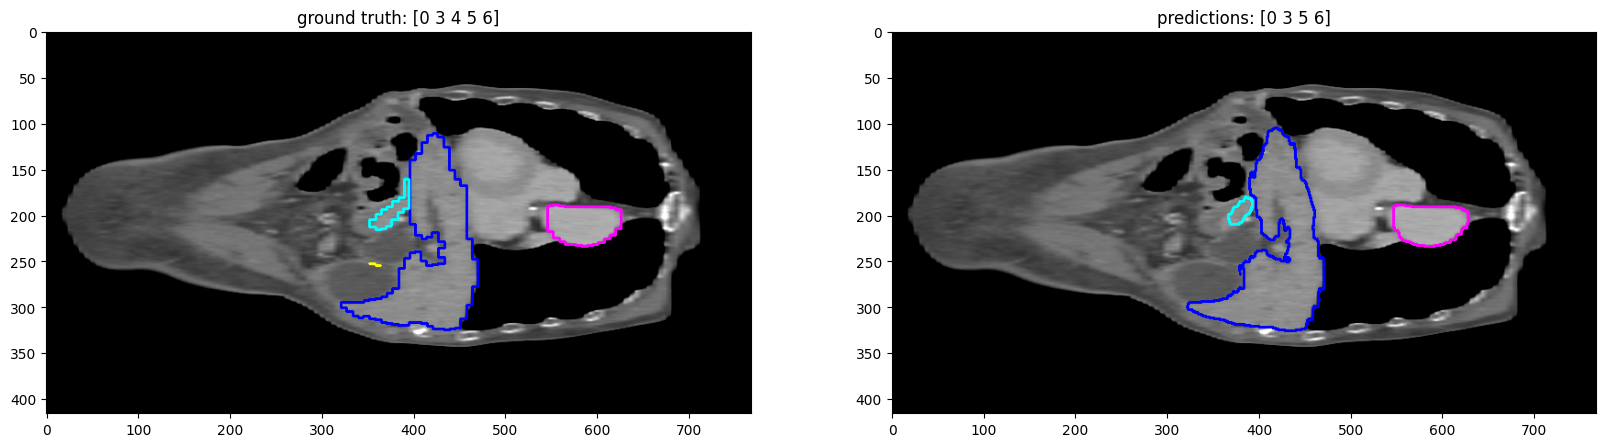

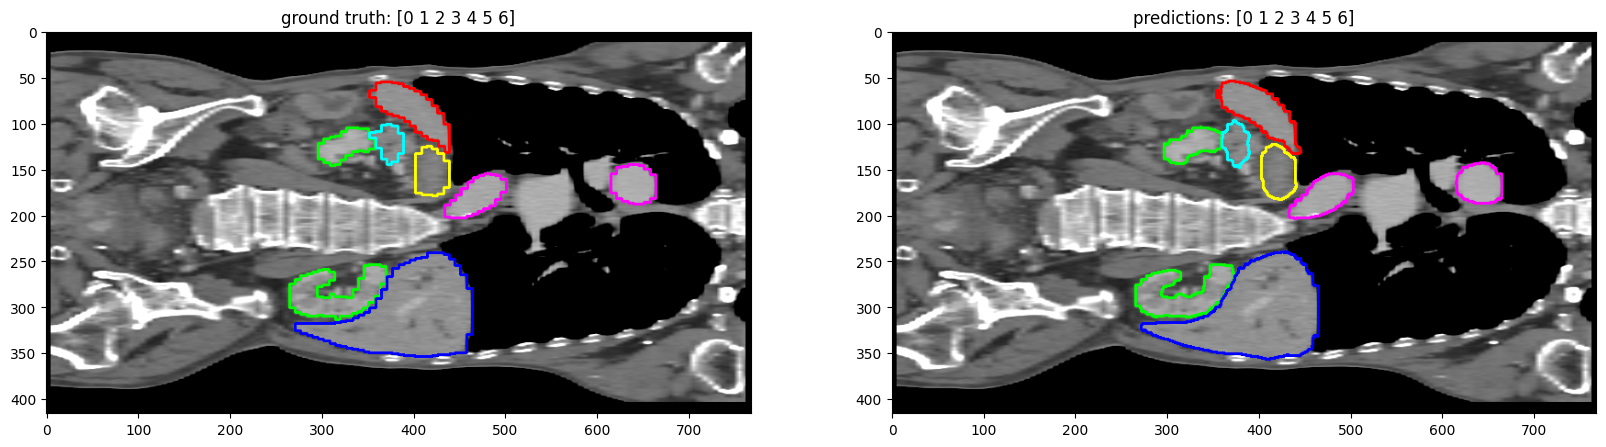

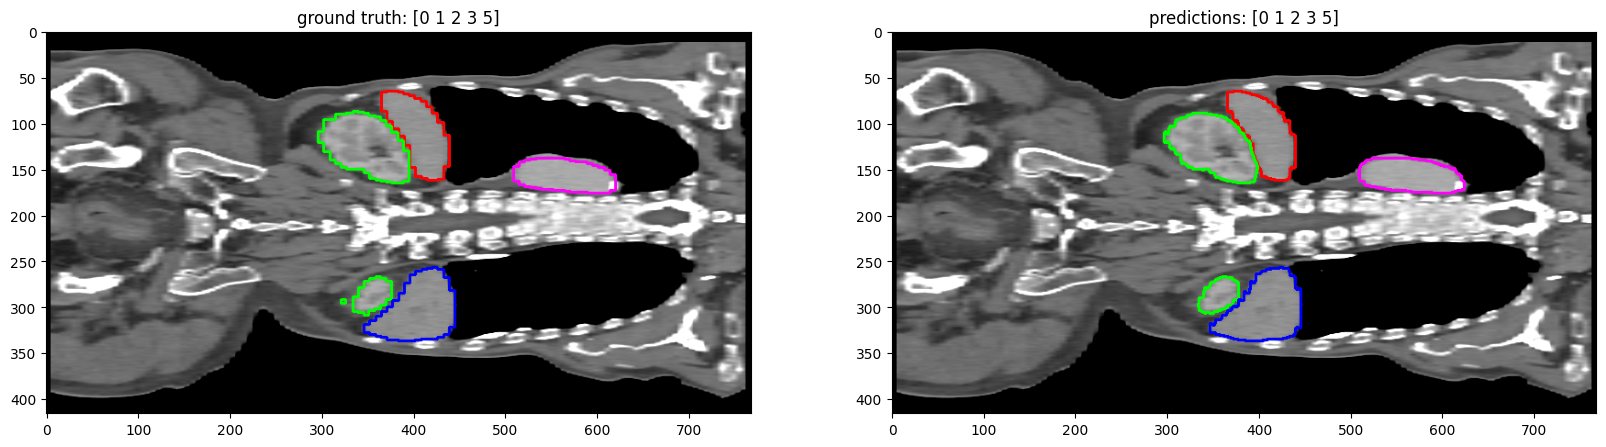

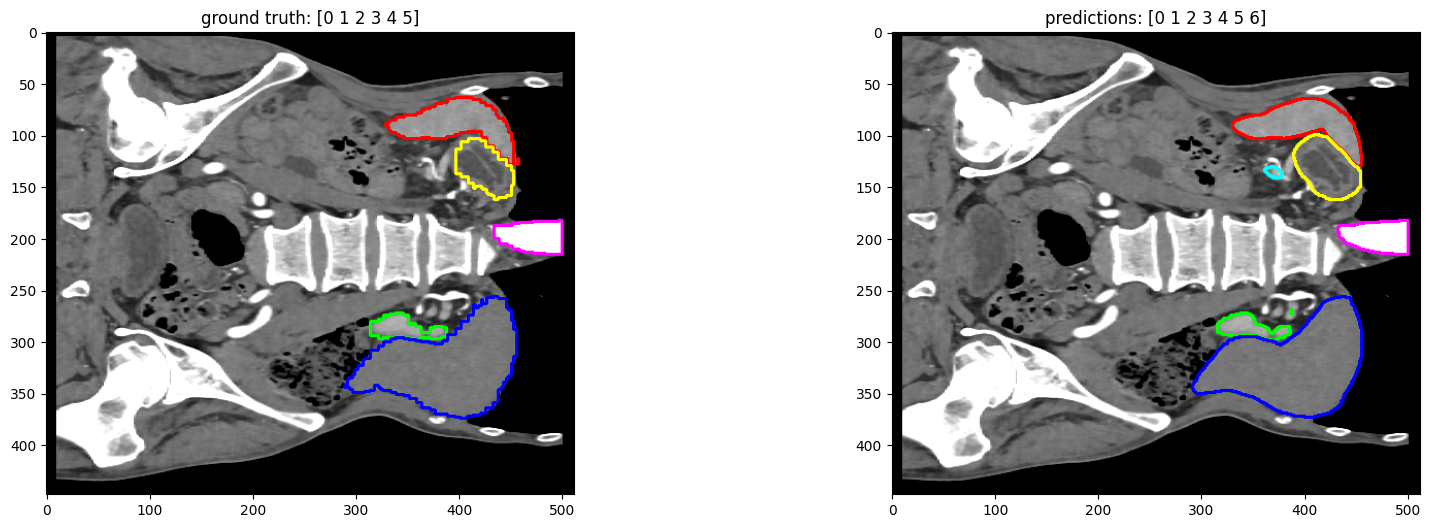

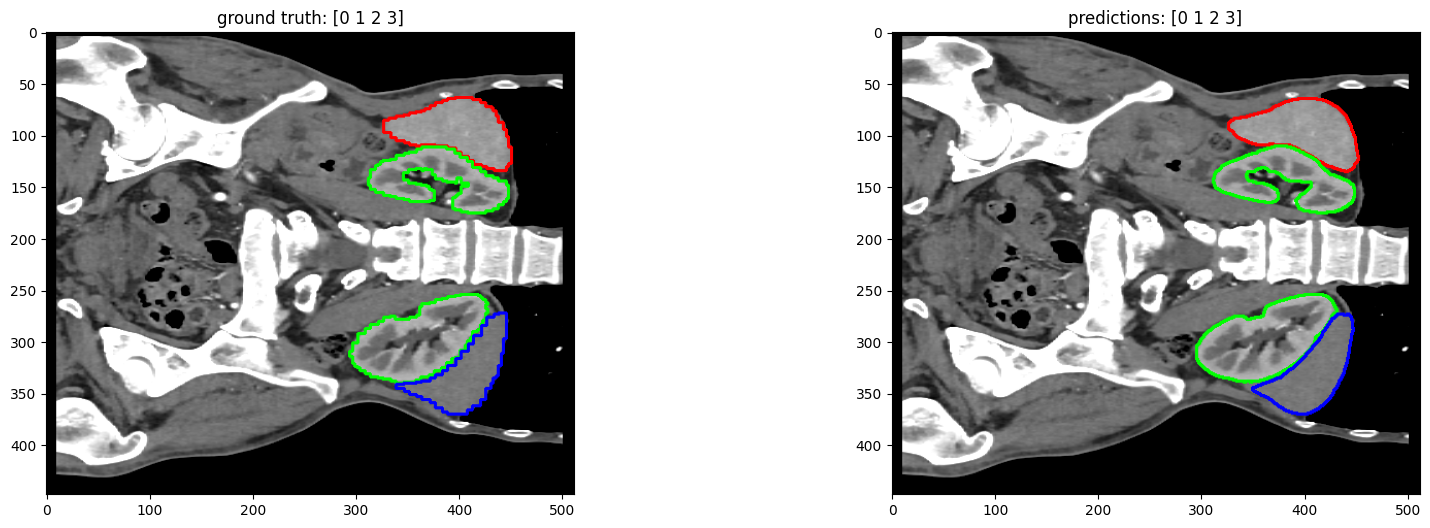

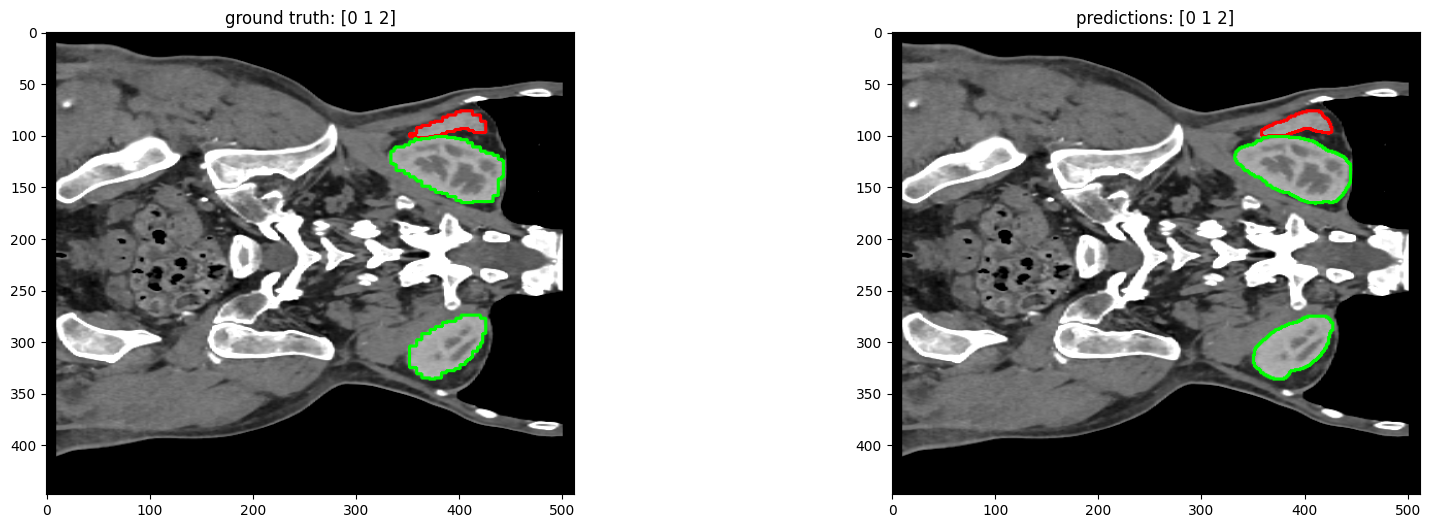

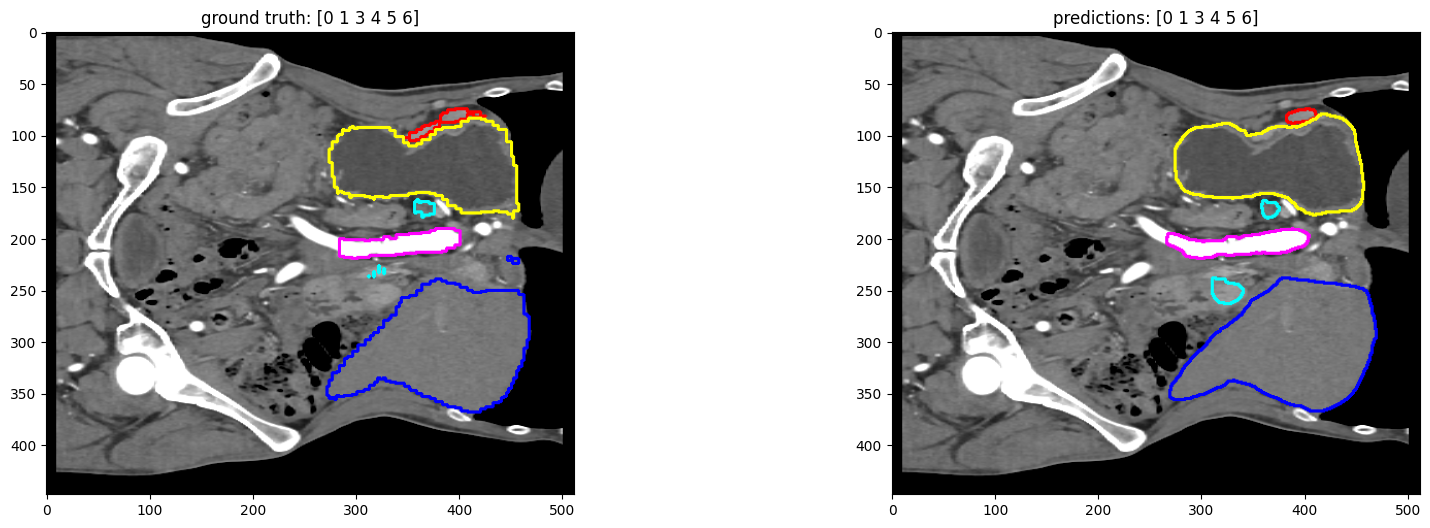

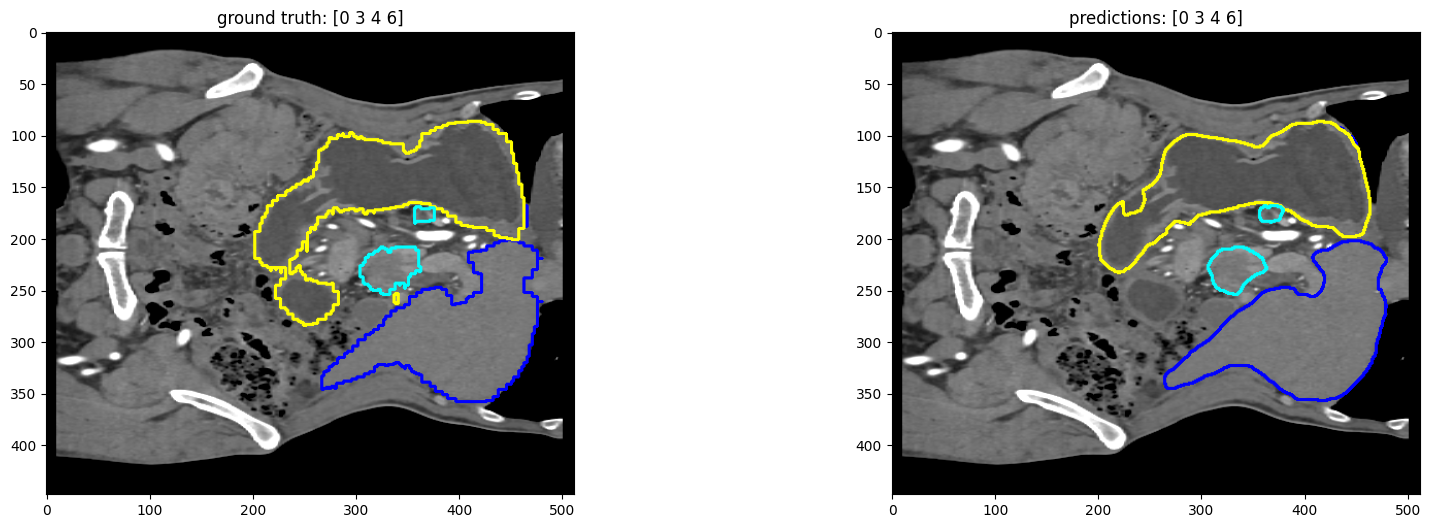

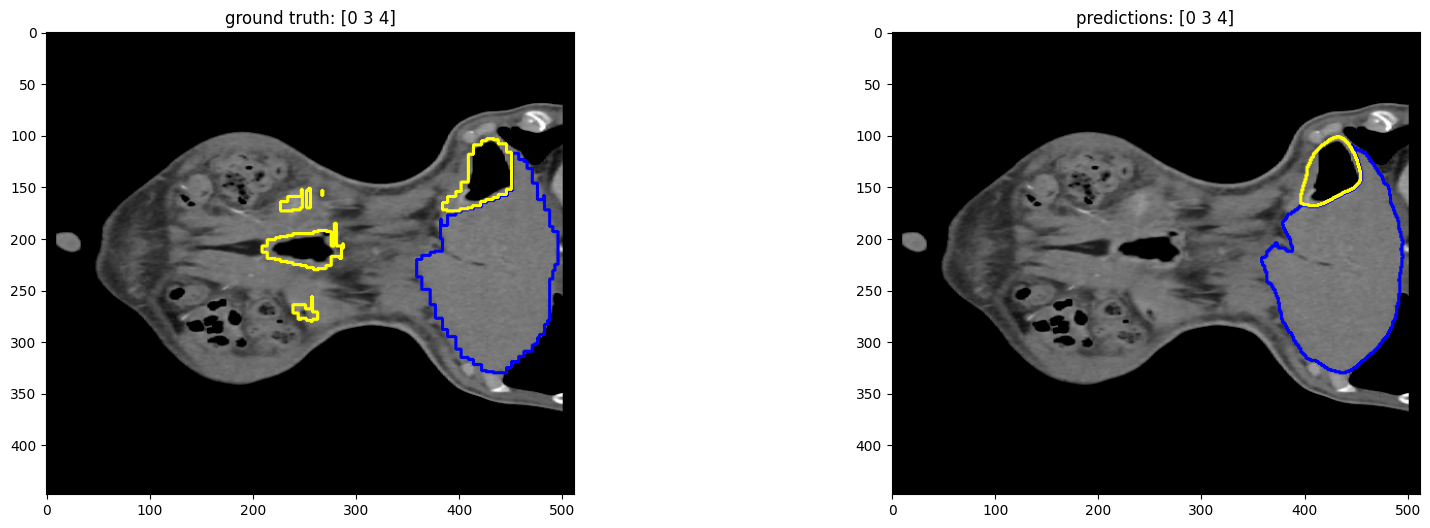

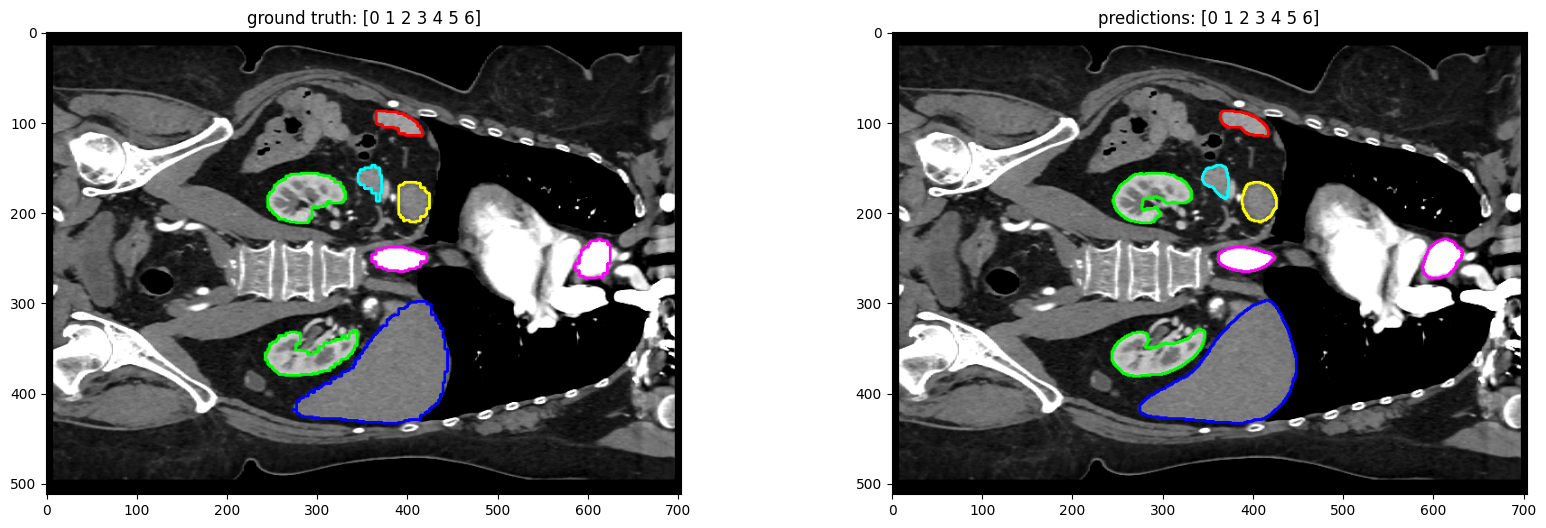

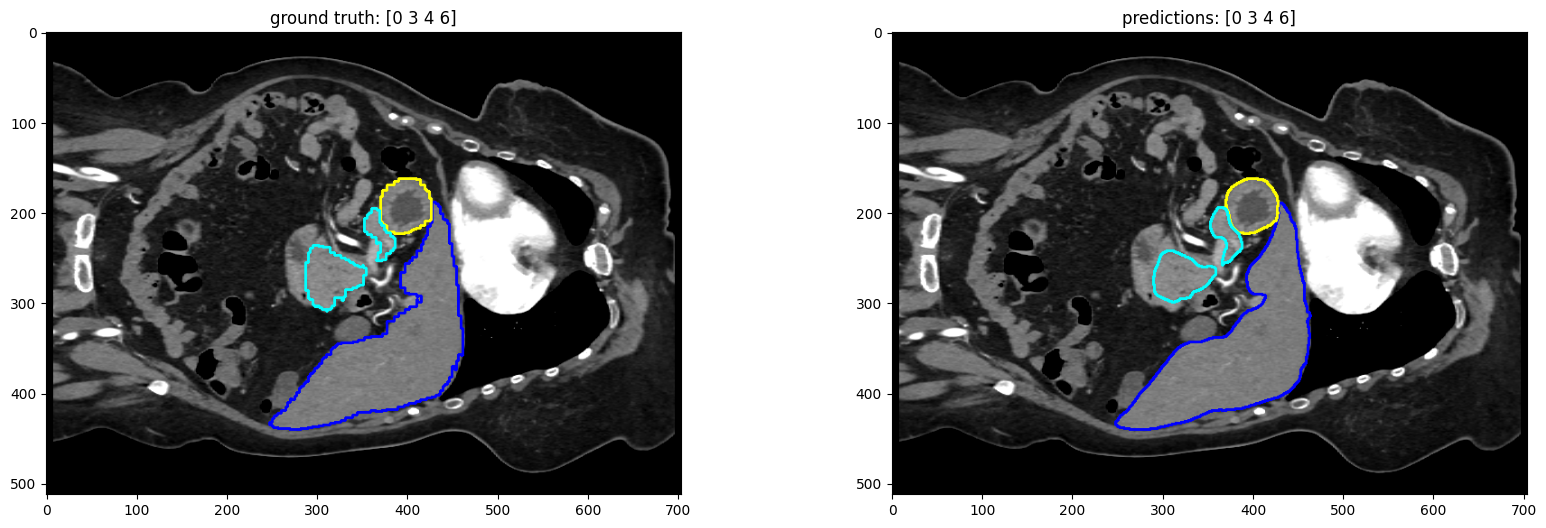

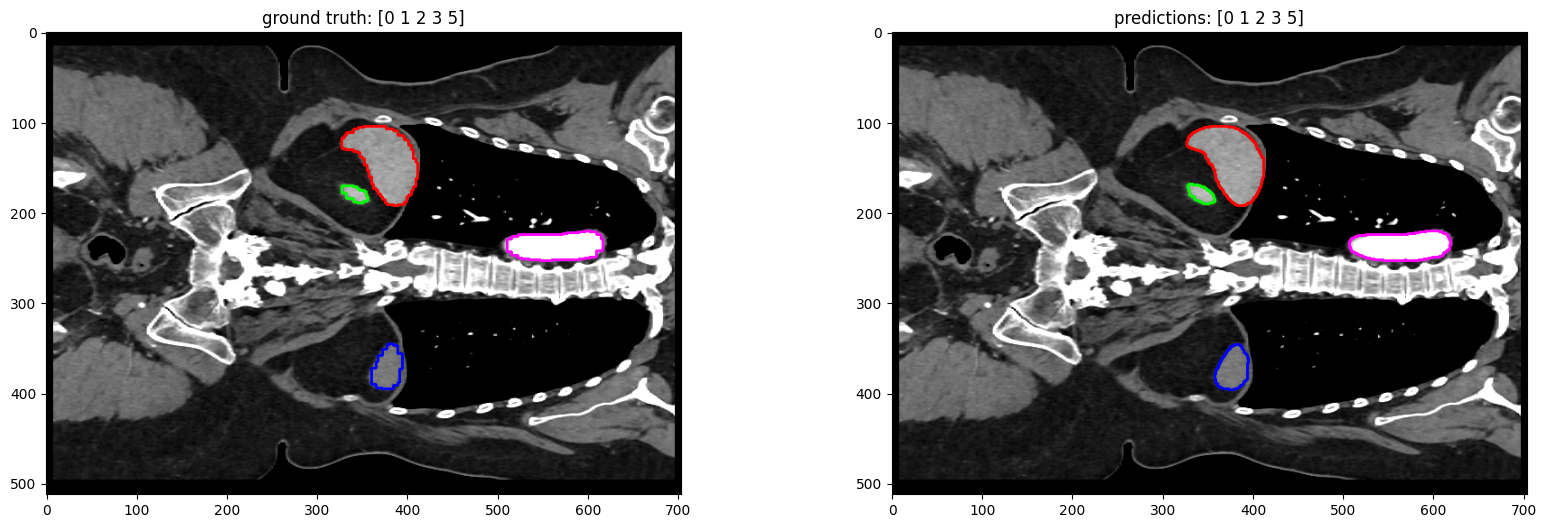

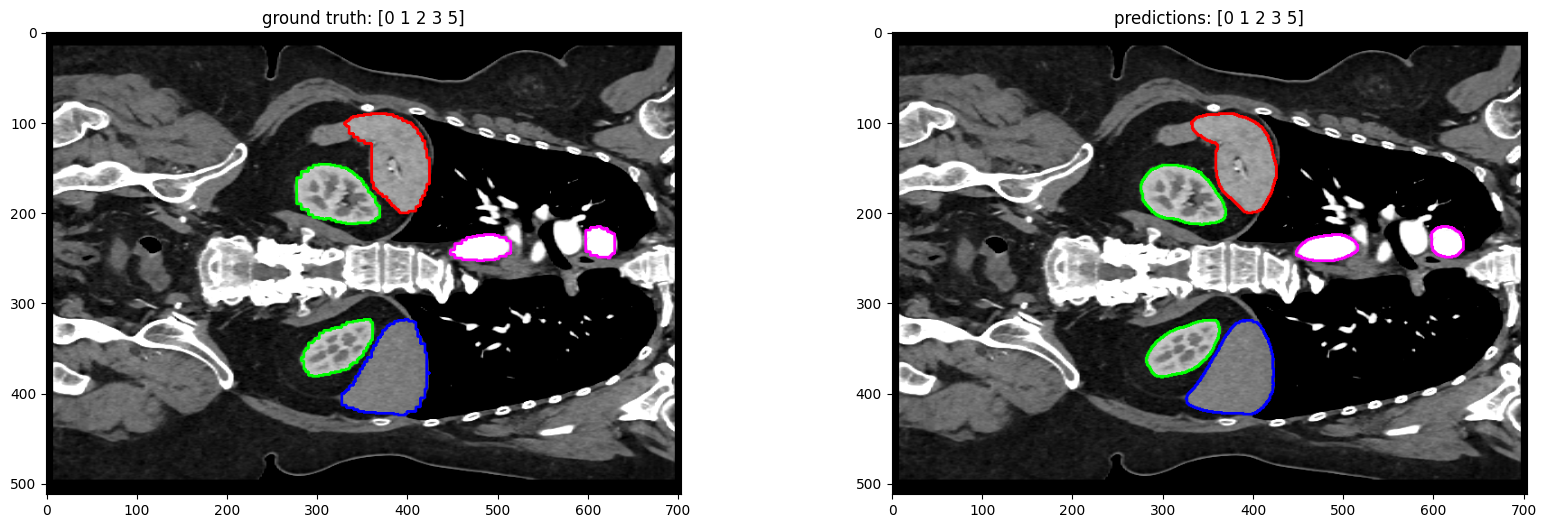

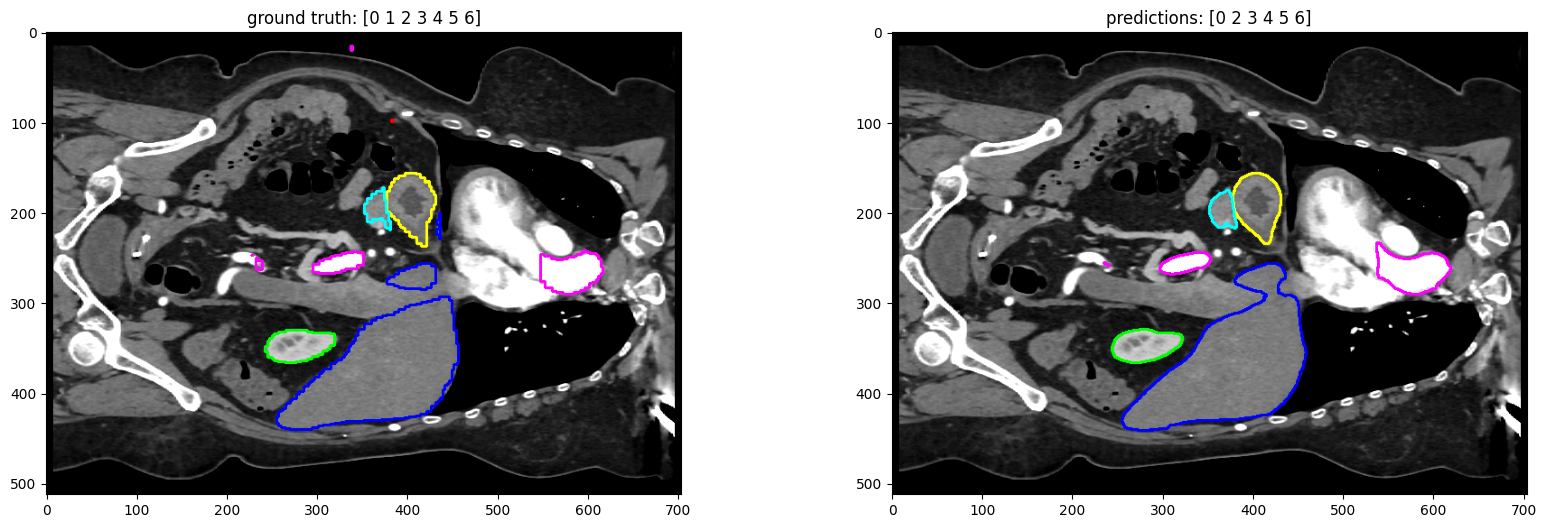

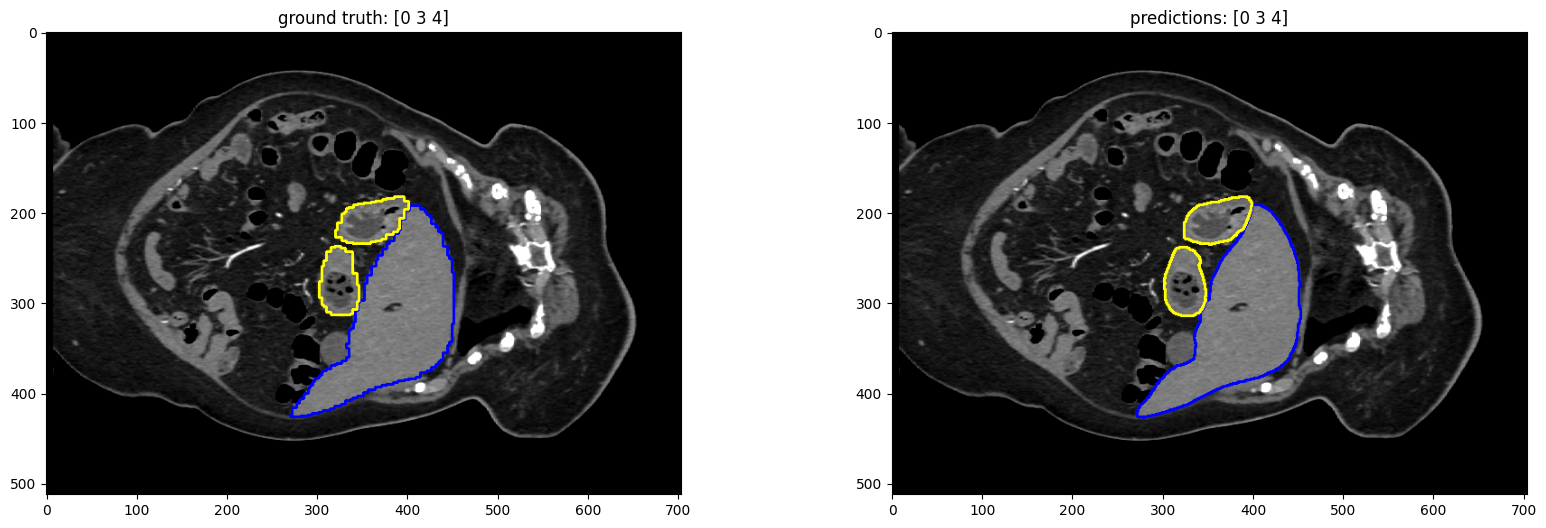

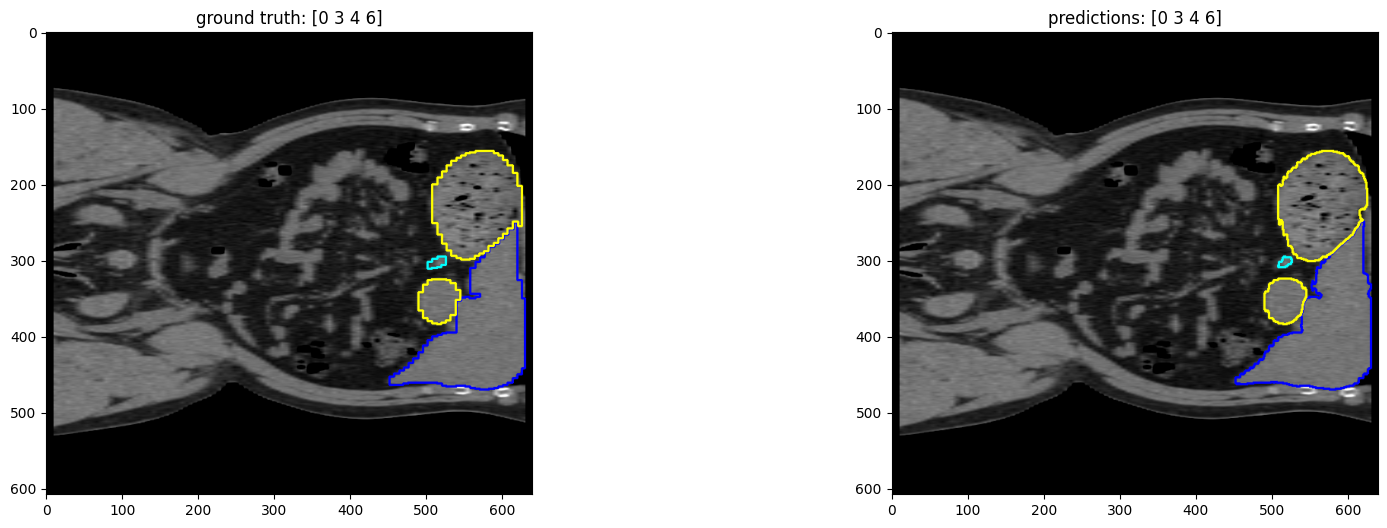

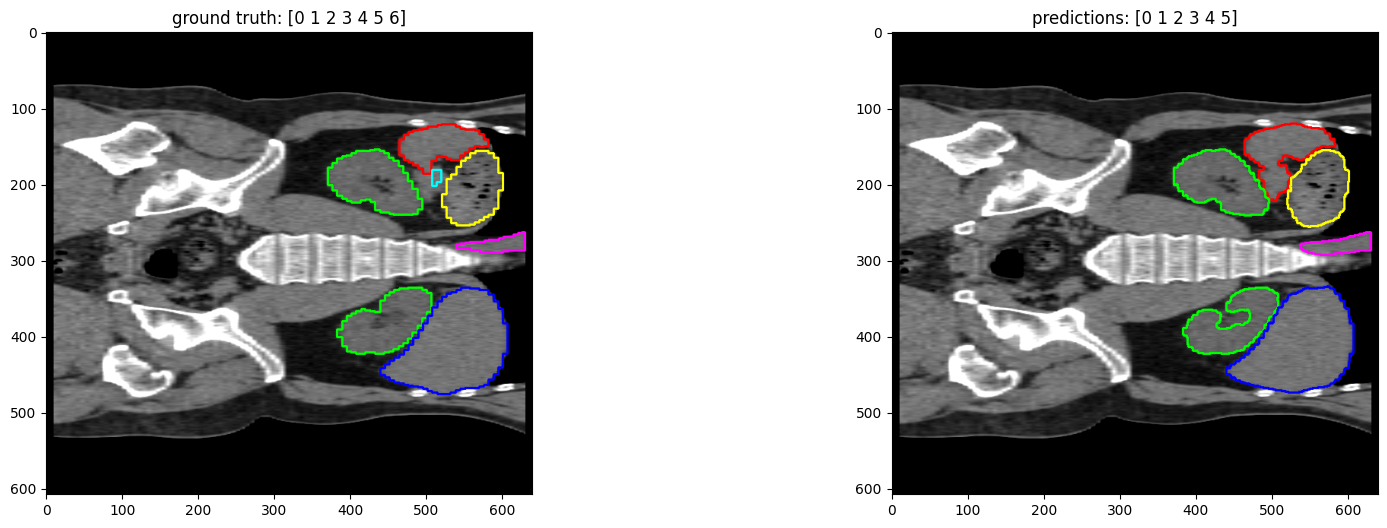

In [28]:
for i in range(20):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

  ax[0].imshow(draw_contours(X[i], Y[i]))
  ax[0].set_title(f'ground truth: {np.unique(Y[i])}')
  ax[1].imshow(draw_contours(X[i], pred[i]))
  ax[1].set_title(f'predictions: {np.unique(pred[i])}')
  fig.show()